## IMPORT LIBRARY

Import the required libraries such as the numpy library, matplotlib, sklearn and others.

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import joblib
import keras
import tensorflow as tf 

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import RobustScaler, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, classification_report, jaccard_score, log_loss, mean_squared_error, confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import cross_val_score
from keras.utils import np_utils
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l2
from keras.optimizers import SGD

## IMPORT DATASET

Calling the dataset in csv format and stored in the "df_train" variable then displaying the top 5 data using the .head() syntax



In [61]:
df = pd.read_csv("/content/drive/MyDrive/ML Penyiraman/data.csv") 
df.head()

,Altitude,Kecepatan Angin,Kecepatan drone,Target
0,0.071035,0.358517,0.481202,0
1,0.190111,0.891837,0.641181,0
2,0.999865,0.377485,0.480633,0
3,0.038556,0.951045,0.344267,0
4,0.373166,0.947603,0.313391,0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Exploratory Data Analysis (EDA)

In the early stages of EDA, the first thing to do is look at the information from the dataset using the info() syntax. By using this syntax we can see the amount of data in each column and the data type. Because this dataset aims to predict whether the company will go bankrupt or not, the data needed is data in int and float format. After that other information can be seen using the syntax describe(). With this syntax we can see the average value and standard deviation of the dataset.

In [8]:
df_train.info()
df_train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 675 entries, 0 to 674
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Altitude         675 non-null    float64
 1   Kecepatan Angin  675 non-null    float64
 2   Kecepatan drone  675 non-null    float64
 3   Target           675 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 21.2 KB


,Altitude,Kecepatan Angin,Kecepatan drone,Target
count,675.000000,675.000000,675.000000,675.000000
mean,2.648344,2.643629,1.980784,1.000000
std,2.333865,2.266247,1.600657,0.817102
min,0.000782,0.000759,0.003638,0.000000
25%,0.719317,0.733808,0.736269,0.000000
50%,1.912882,2.023685,1.526767,1.000000
75%,4.119889,3.988719,2.921309,2.000000
max,7.965762,7.940034,5.918892,2.000000


Karena dataset ini termasuk pada klasifikasi maka balancing data target harus diperhatikan. Cara melihatnya dapat menggunakan syntax value_counts() untuk mengetahui jumlah data pada setiap kolom.

In [10]:
df_train['Target'].value_counts()

0    225
1    225
2    225
Name: Target, dtype: int64

This syntax aims to check whether in this dataset there is null data or duplicate data. If there is then the data must be deleted or replaced with the data that should be. Because in this dataset there are no null data and duplicated data, the data drop or fill data stage is not needed.

In [11]:
print("=========== Sum null of dataset================== ")
print(df_train.isnull().sum())
print("=========== Sum Duplicate of dataset================== ")
df_train[df_train.duplicated()]

=========== Sum null of dataset================== 
Altitude           0
Kecepatan Angin    0
Kecepatan drone    0
Target             0
dtype: int64
=========== Sum Duplicate of dataset================== 


,Altitude,Kecepatan Angin,Kecepatan drone,Target


After that look at the correlation between the data. In the image below, what must be seen is the correlation between the price_range data and other data. If you look at the picture, the highest correlation is found in RAM data, which is 0.92, while the other data is quite bad.



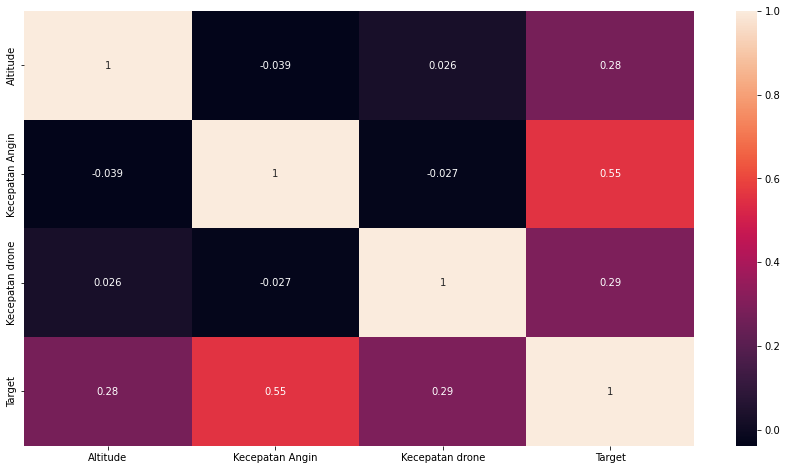

In [12]:
plt.figure(figsize=(15, 8))
sns.heatmap(df_train.corr(), annot=True)
plt.show()

Then look at the distribution of data in the dataset using boxplot plots. By using a boxplot you can also check whether the data has outliers or not. If there is then the outlier must be removed. And from this plot, the "fc" and "px_height" data columns have outliers so that the outliers for these two columns must be removed in order to eliminate noise when modeling.



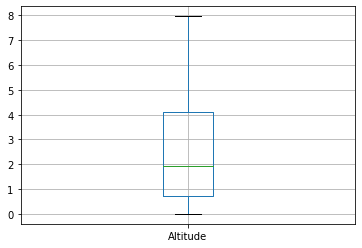

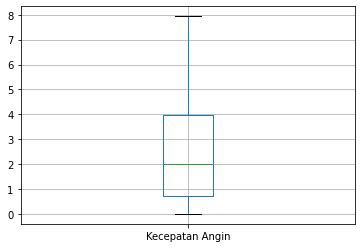

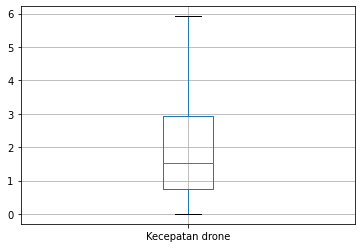

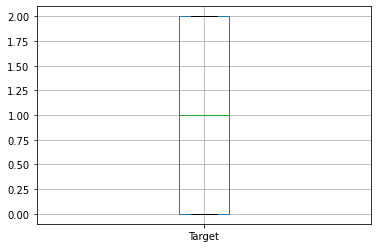

In [13]:
for column in df_train:
    plt.figure()
    df_train.boxplot([column])

Dibawah ini merupakan syntax untuk menghapus outlier dengan menggunakan selisih antara quantile 3 dan quantile 1.

In [ ]:
num_var = ['fc', 'px_height']
for i in num_var:
    Q1 = df_train[i].quantile(0.25)
    Q3 = df_train[i].quantile(0.75)
    IQR = Q3 - Q1
    df_train[i] = np.where(df_train[i]>(Q3+1.5*IQR),(Q3+1.5*IQR),df_train[i])
    df_train[i] = np.where(df_train[i]<(Q1-1.5*IQR),(Q1-1.5*IQR),df_train[i])

Mengecek kembali apakah data tersebut outliernya sudah terhapus atau belum.

<ipython-input-12-d2ecf9fdaf3f>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


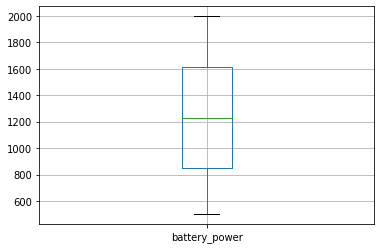

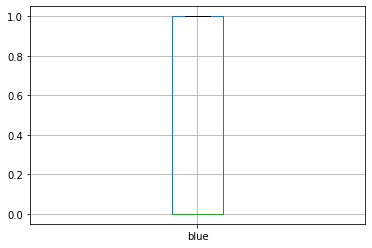

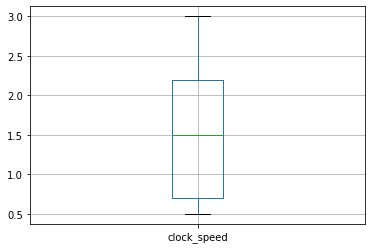

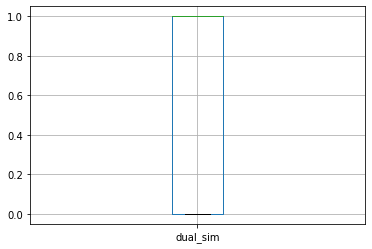

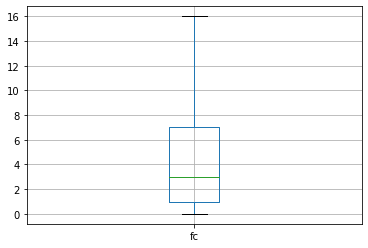

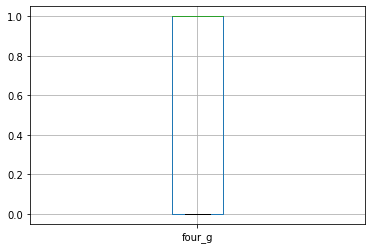

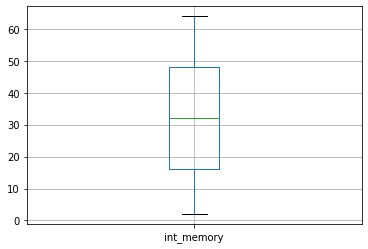

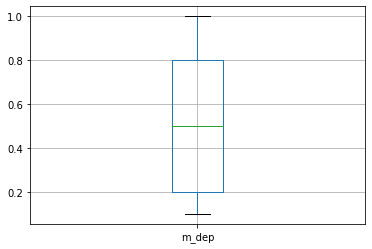

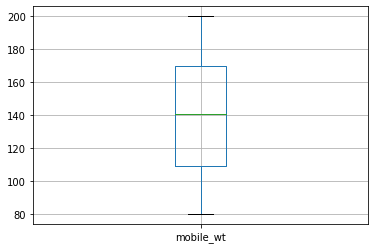

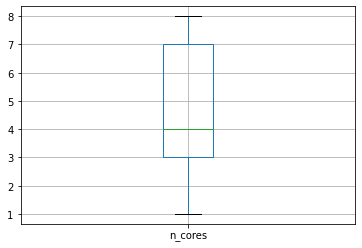

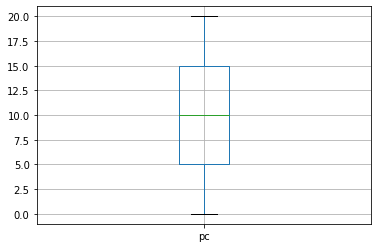

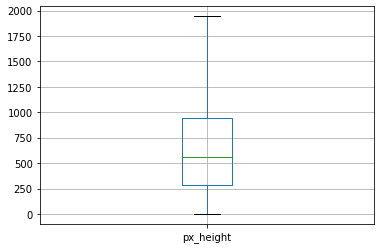

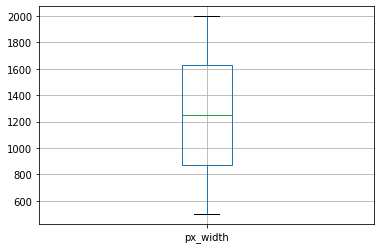

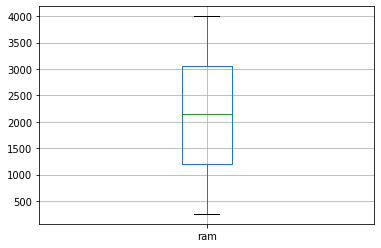

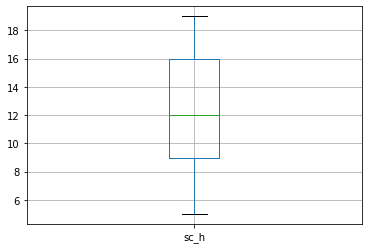

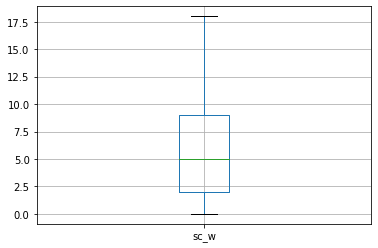

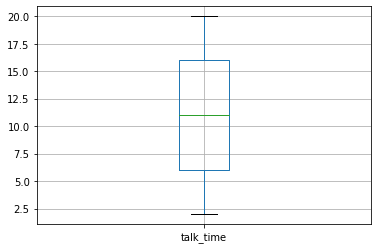

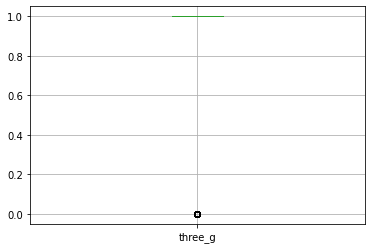

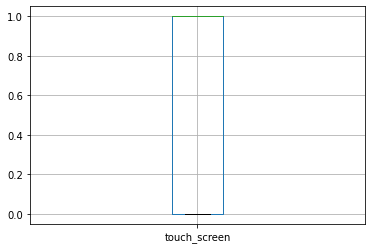

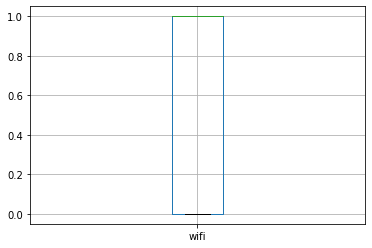

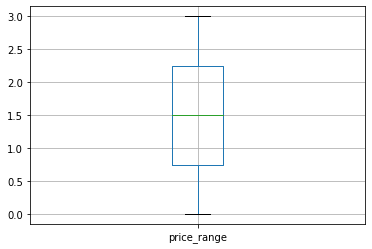

In [ ]:
for column in df_train:
    plt.figure()
    df_train.boxplot([column])

Setelah itu melihat juga sebaran data menggunakan ploting histogram.

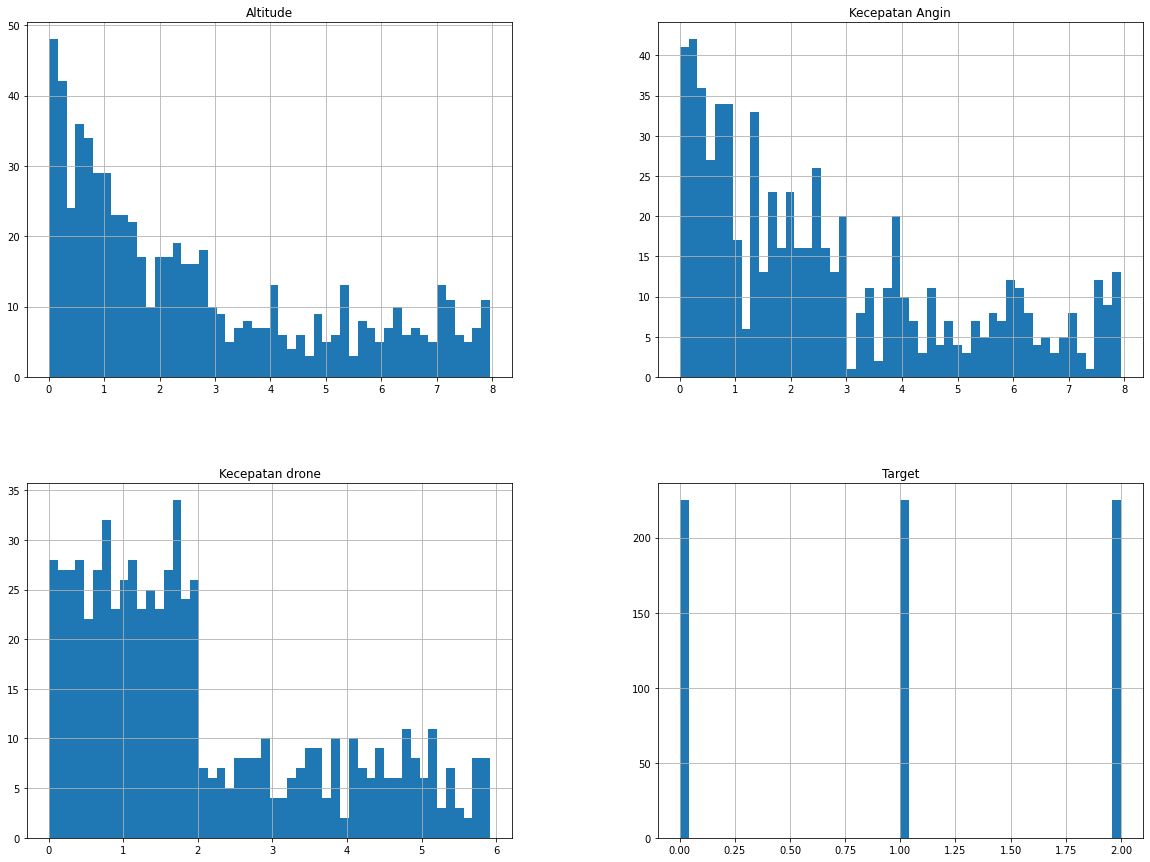

In [14]:
df_train.hist(bins=50, figsize=(20,15))
plt.show()

After the information from the dataset is sufficient, the next step is to separate the data between feature data and target data. The reason is because the next stage is data scaling and data scaling is only done on feature data.

In [ ]:
X = df_train.drop('price_range', axis=1).reset_index(drop=True)
y = df_train['price_range'].reset_index(drop=True)

At this stage, scaling the data using a standard scaler. The purpose of the standard scaler is to make the mean value 0 and the variance 1.

In [ ]:
tf = StandardScaler().fit_transform(X)
scaledf = pd.DataFrame(tf, columns=X.columns)
scaledf['price_range'] = y
scaledf

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,-0.902597,-0.990050,0.830779,-1.019184,-0.766948,-1.043966,-1.380644,0.340740,1.349249,-1.101971,...,-1.409023,-1.146784,0.391703,-0.784983,0.283103,1.462493,-1.786861,-1.006018,0.986097,1
1,-0.495139,1.010051,-1.253064,0.981177,-0.999780,0.957886,1.155024,0.687548,-0.120059,-0.664768,...,0.585842,1.704465,0.467317,1.114266,-0.635317,-0.734267,0.559641,0.994018,-1.014099,2
2,-1.537686,1.010051,-1.253064,0.981177,-0.534116,0.957886,0.493546,1.381165,0.134244,0.209639,...,1.392805,1.074968,0.441498,-0.310171,-0.864922,-0.368140,0.559641,0.994018,-1.014099,2
3,-1.419319,1.010051,1.198517,-1.019184,-0.999780,-1.043966,-1.215274,1.034357,-0.261339,0.646842,...,1.286863,1.236971,0.594569,0.876859,0.512708,-0.002014,0.559641,-1.006018,-1.014099,2
4,1.325906,1.010051,-0.395011,-1.019184,2.027033,0.957886,0.658915,0.340740,0.021220,-1.101971,...,1.268830,-0.091452,-0.657666,-1.022389,-0.864922,0.730240,0.559641,0.994018,-1.014099,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-1.011860,1.010051,-1.253064,0.981177,-0.999780,0.957886,-1.656260,1.034357,-0.967737,0.646842,...,1.300387,1.477661,-1.342799,0.164641,-0.405712,1.462493,0.559641,0.994018,-1.014099,0
1996,1.653694,1.010051,1.321096,0.981177,-0.999780,-1.043966,0.383299,-1.046495,1.320993,-0.227564,...,0.608383,1.651235,-0.085031,-0.310171,0.971917,0.913303,0.559641,0.994018,0.986097,2
1997,1.530773,-0.990050,-0.762748,0.981177,-0.766948,0.957886,0.217930,0.687548,-0.911225,1.521249,...,0.502441,0.880565,0.860139,-0.784983,-1.094526,-1.100394,0.559641,0.994018,-1.014099,3
1998,0.622527,-0.990050,-0.762748,-1.019184,-0.068453,0.957886,0.769162,-1.393304,0.134244,0.209639,...,-0.696732,-1.345816,-1.157454,1.351672,0.971917,1.462493,0.559641,0.994018,0.986097,0


Then the data that has been scaled will be divided into 4 parts, namely x_test, x_train, y_train, and y_test. The division of the data is 80% train data and 20% test data.


In [17]:
xx = df.drop('Target', axis=1)
yy = df['Target']
X_train, X_test, y_train, y_test = train_test_split(xx, yy, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(540, 3) (540,) (135, 3) (135,)


Create a validation variable by means of reverse data.

In [18]:
x_val = X_train[-135:]
y_val = y_train[-135:]

Create a model using Sequential. This model consists of 3 layers, 1 input layer uses 20 nodes because there are 20 feature columns and uses Relu activation with the aim of making negative values ​​become 0 and data above 0 will remain. Next, 1 hidden layer uses 2 nodes and activates Relu. After that, 1 layer output layer uses 4 nodes, the reason is that this dataset targets 4 classes, namely 0,1,2,3, so this dataset includes a multiclass classification. For that reason, the activation function used is softmax.

In [90]:
model = keras.Sequential()
model.add(Dense(units = 3, activation='relu', input_dim= 3)) #input layer
model.add(Dense(units = 256, activation='relu')) #hidden layer
model.add(Dense(units = 256, activation='relu')) #hidden layer
model.add(Dense(units = 128, activation='relu')) #hidden layer
model.add(Dense(units = 128, activation='relu')) #hidden layer
model.add(Dense(units = 64, activation='relu')) #hidden layer
model.add(Dense(units = 64, activation='relu')) #hidden layer
model.add(Dense(units = 3, activation='softmax')) # output layer

Here is a summery model that has been made

In [91]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 3)                 12        
                                                                 
 dense_31 (Dense)            (None, 256)               1024      
                                                                 
 dense_32 (Dense)            (None, 256)               65792     
                                                                 
 dense_33 (Dense)            (None, 128)               32896     
                                                                 
 dense_34 (Dense)            (None, 128)               16512     
                                                                 
 dense_35 (Dense)            (None, 64)                8256      
                                                                 
 dense_36 (Dense)            (None, 64)               

The next stage is compiling the model. The optimizer used is SGD with a learning rate of 0.001. Then the loss used is sparse categorical crossentropy, this loss was chosen because for the multiclass loss classification case used is sparse categorical crossentropy. And for the metrics use accuracy.

In [92]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

Then the model will be fitted with batch size 16 and epoch 200. And obtained loss 0.3735, accuracy 0.9050, val loss 0.3740, and val accuracy 0.9050



In [93]:
history = model.fit(
    X_train,
    y_train,
    batch_size=16,
    epochs=4000,
    validation_data=(x_val, y_val),
)


Streaming output truncated to the last 5000 lines.
34/34 [==============================] - 0s 5ms/step - loss: 0.4305 - accuracy: 0.8278 - val_loss: 0.3665 - val_accuracy: 0.8741
Epoch 1502/4000
34/34 [==============================] - 0s 6ms/step - loss: 0.4299 - accuracy: 0.8407 - val_loss: 0.3585 - val_accuracy: 0.8815
Epoch 1503/4000
34/34 [==============================] - 0s 6ms/step - loss: 0.4339 - accuracy: 0.8278 - val_loss: 0.4209 - val_accuracy: 0.8148
Epoch 1504/4000
34/34 [==============================] - 0s 6ms/step - loss: 0.4342 - accuracy: 0.8259 - val_loss: 0.4228 - val_accuracy: 0.8222
Epoch 1505/4000
34/34 [==============================] - 0s 5ms/step - loss: 0.4306 - accuracy: 0.8426 - val_loss: 0.3626 - val_accuracy: 0.8815
Epoch 1506/4000
34/34 [==============================] - 0s 6ms/step - loss: 0.4302 - accuracy: 0.8278 - val_loss: 0.3560 - val_accuracy: 0.8741
Epoch 1507/4000
34/34 [==============================] - 0s 5ms/step - loss: 0.4281 - accuracy:

Plotting the loss and accuracy of the model that has been made.

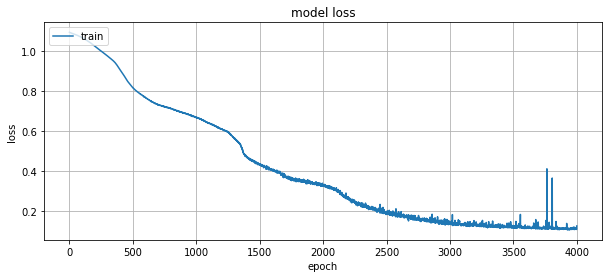

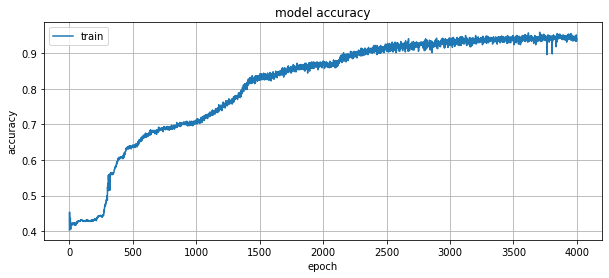

In [94]:
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

Calling the dataset to test. Because in this dataset the test data and training data are separated.

Make a program to see the prediction results using "X_test"

In [46]:
prediksi = model.predict([0.1],[0.1],[0.1])
ypred = np.array(prediksi)
ypred

TypeError: ignored

In [95]:
x = 0
y = 1
hasil_prediksi = []
for i in range(80):
  prediksi = model.predict(X_test[x:y])
  kelas = np.argmax(prediksi)
  hasil_prediksi.append(kelas)
  x+=1
  y+=1
print(hasil_prediksi)
ypred = np.array(hasil_prediksi)

1/1 [==============================] - 0s 44ms/step
[2, 1, 2, 1, 2, 0, 2, 1, 2, 0, 0, 2, 0, 0, 0, 0, 1, 1, 1, 0, 2, 2, 1, 1, 0, 1, 2, 2, 1, 2, 2, 0, 1, 1, 1, 0, 0, 1, 2, 0, 2, 0, 2, 1, 2, 0, 0, 2, 2, 1, 1, 1, 2, 2, 0, 0, 0, 2, 1, 2, 0, 2, 1, 2, 1, 2, 0, 0, 1, 1, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0]


In [97]:
data = {'Altitude': [0.1,1.2,5.3,0.000001],
        'Kecepatan Angin' : [0.2,1.5,4.5,0.000001],
        'Kecepatan drone': [0.5,1.6,4.7,0.00001]}
data_test = pd.DataFrame(data)
data_test

,Altitude,Kecepatan Angin,Kecepatan drone
0,0.100000,0.200000,0.50000
1,1.200000,1.500000,1.60000
2,5.300000,4.500000,4.70000
3,0.000001,0.000001,0.00001


In [98]:
x = 0
y = 1
hasil_prediksi = []
for i in range(4):
  prediksi = model.predict(data_test[x:y])
  kelas = np.argmax(prediksi)
  hasil_prediksi.append(kelas)
  x+=1
  y+=1
print(hasil_prediksi)
ypred = np.array(hasil_prediksi)

1/1 [==============================] - 0s 28ms/step
[0, 1, 2, 0]


In [52]:
X_test[0:1]

,Altitude,Kecepatan Angin,Kecepatan drone
396,1.257054,3.891919,0.421136


Kemudian melihat Confusion matrix hasil dari model tersebut yang disimpan pada variabel ypred dan dibandingkan dengan variabel y_test. Dapat dilihat f1 score yang didapatkan dari model ini adalah 93%.

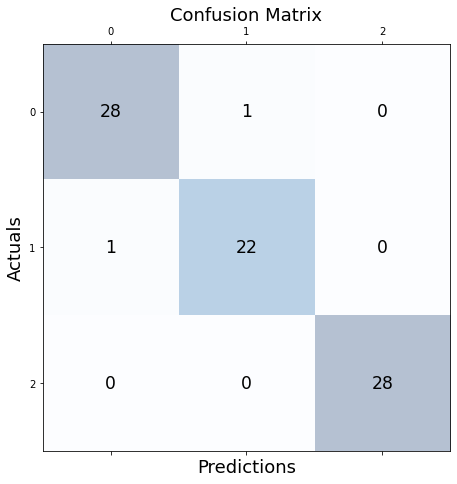

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        29
           1       0.96      0.96      0.96        23
           2       1.00      1.00      1.00        28

    accuracy                           0.97        80
   macro avg       0.97      0.97      0.97        80
weighted avg       0.97      0.97      0.97        80



In [96]:
conf_matrix = confusion_matrix(y_true=y_test[0:80], y_pred=ypred)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
  for j in range(conf_matrix.shape[1]):
    ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
report = classification_report(ypred, y_test[0:80])
print(report)

After that, we try to plot the test data or y-test using the dot plot with the aim that later it will be compared with the plotted data of the predicted results



In [99]:
model.save('percobaan3.h5') 

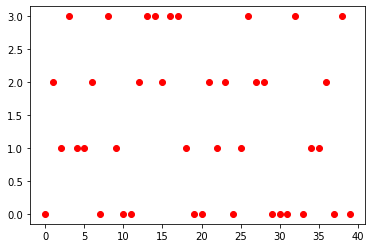

In [ ]:
y_test_array = np.array(y_test[0:40])
plt.plot(y_test_array, 'ro')
plt.show()

Plot prediction results

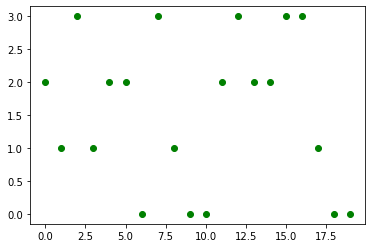

In [ ]:
plt.plot(ypred, 'go')
plt.show()

It can be seen the comparison of plotting on the test data and training data. Only a few data differ between test data and training data.

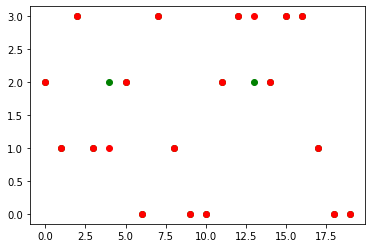

In [ ]:
plt.plot(ypred, 'go')
plt.plot(y_test_array, 'ro')
plt.show()

Classification results using dt_test_scale

In [ ]:
x = 0
y = 1
hasil_prediksi = []
for i in range(20):
  prediksi = model.predict(df_test_scale[x:y])
  kelas = np.argmax(prediksi)
  hasil_prediksi.append(kelas)
  x+=1
  y+=1
print(hasil_prediksi)
ypred = np.array(hasil_prediksi)

1/1 [==============================] - 0s 18ms/step
[3, 3, 2, 3, 1, 3, 3, 1, 3, 0, 3, 3, 0, 0, 2, 0, 2, 1, 3, 2]
